# Requirements

In [33]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from xgboost import XGBRegressor

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **average sea-level pressure** in the city of Skopje. Your task involves employing bagging and boosting methods to forecast the average sea-level pressure. To accomplish this, you will use data from the preceding three days, consisting of average, minimal, and maximal temperatures, precipitation, as well as wind direction and speed, and the current season. By applying these ensemble learning techniques, you aim to enhance the accuracy and reliability of your predictions, gaining valuable insights into the temporal dynamics of sea-level pressure based on the given meteorological variables.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Weather Dataset

## Exploring the Weather Dataset
This dataset consists of daily weather records for the city of Skopje from January 1, 2021, to August 1, 2023. Each entry includes a unique station ID, city name, date, corresponding season (e.g., summer, winter), and various meteorological parameters such as average, minimum, and maximum temperatures in Celsius, precipitation in millimeters, average wind direction in degrees, average wind speed in kilometers per hour, and average sea-level pressure in hectopascals. The dataset offers comprehensive insights into the climatic conditions, allowing for analysis and exploration of weather patterns in Skopje over the specified time period.

The dataset comprises the following columns:
- station_id - unique ID for the weather station,
- city_name - name of the city where the station is located,
- date - date of the weather record,
- season - season corresponding to the date (e.g., summer, winter),
- avg_temp_c - average temperature in Celsius,
- min_temp_c - minimum temperature in Celsius,
- max_temp_c - maximum temperature in Celsius,
- precipitation_mm - precipitation in millimeters,
- avg_wind_dir_deg - average wind direction in degrees,
- avg_wind_speed_kmh - average wind speed in kilometers per hour, and
- avg_sea_level_pres_hpa - average sea-level pressure in hectopascals.

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [2]:
df = pd.read_csv('data/weather.csv')

In [3]:
df.head()

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
0,13588,Skopje,2021-01-01,Winter,5.1,0.5,13.2,0.0,330.0,5.9,1021.2
1,13588,Skopje,2021-01-02,Winter,3.0,-2.6,11.2,0.0,330.0,5.9,1021.2
2,13588,Skopje,2021-01-03,Winter,6.8,3.5,12.5,1.3,339.0,8.0,1017.8
3,13588,Skopje,2021-01-04,Winter,6.6,6.1,7.2,3.6,298.0,5.3,1011.3
4,13588,Skopje,2021-01-05,Winter,4.3,2.3,6.7,4.6,11.0,5.1,1014.5


In [4]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(keys=['date'], inplace=True)
df.sort_index(inplace=True)
df.head()

,station_id,city_name,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
date,,,,,,,,,,
2021-01-01,13588,Skopje,Winter,5.1,0.5,13.2,0.0,330.0,5.9,1021.2
2021-01-02,13588,Skopje,Winter,3.0,-2.6,11.2,0.0,330.0,5.9,1021.2
2021-01-03,13588,Skopje,Winter,6.8,3.5,12.5,1.3,339.0,8.0,1017.8
2021-01-04,13588,Skopje,Winter,6.6,6.1,7.2,3.6,298.0,5.3,1011.3
2021-01-05,13588,Skopje,Winter,4.3,2.3,6.7,4.6,11.0,5.1,1014.5


In [5]:
df.drop(columns=['station_id', 'city_name'], inplace=True)

Explore the dataset using visualizations of your choice.

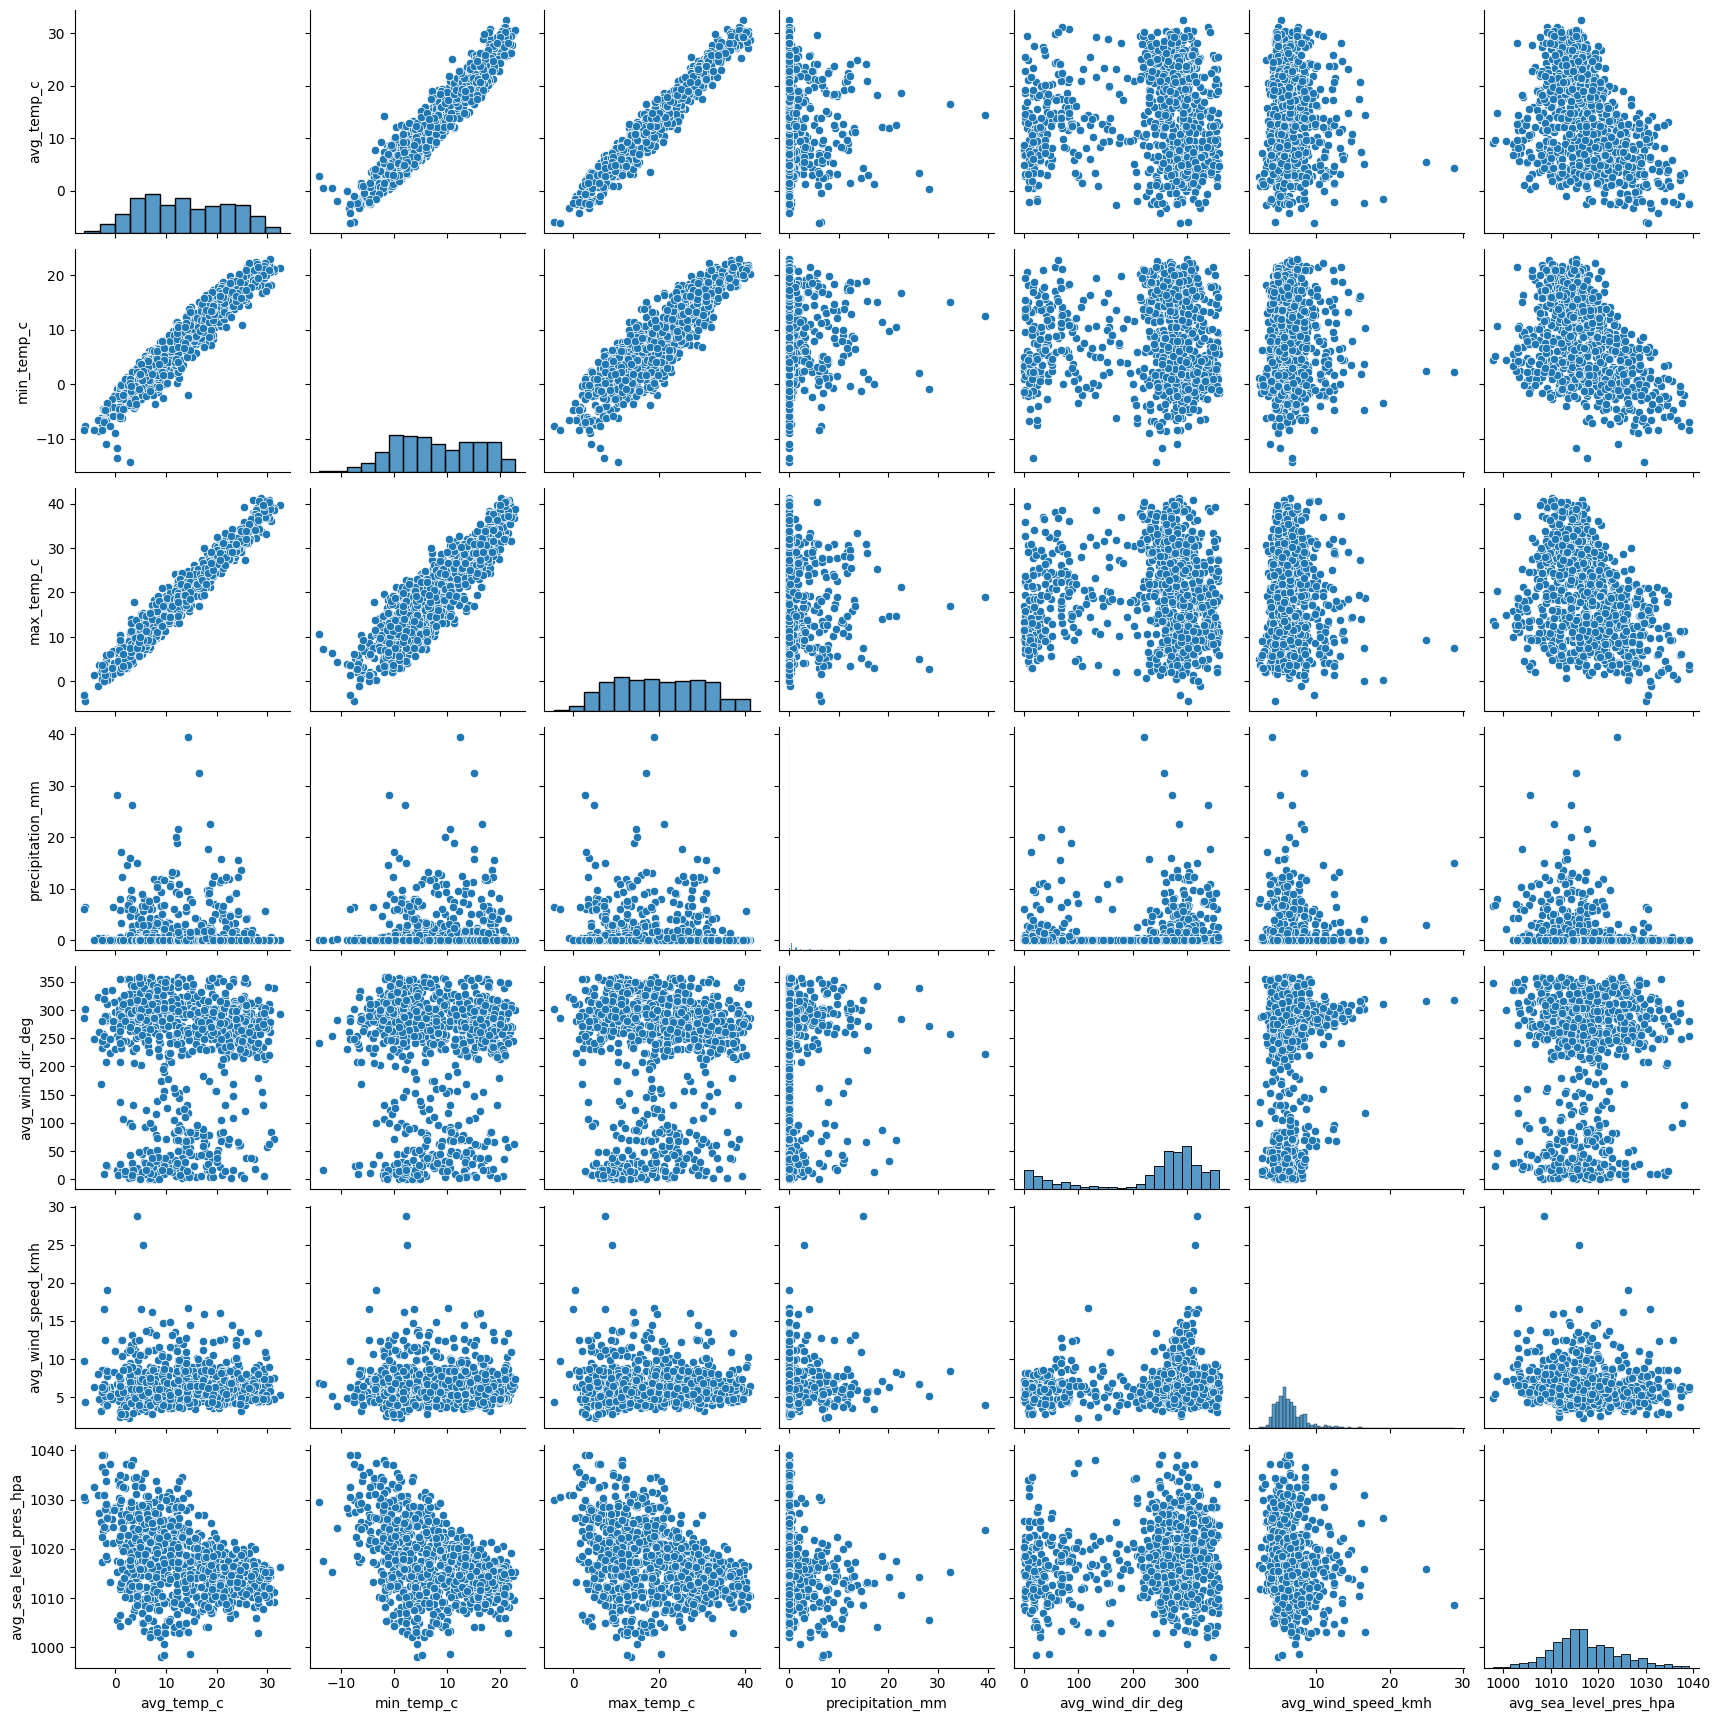

In [6]:
sns.pairplot(df)

<Axes: >

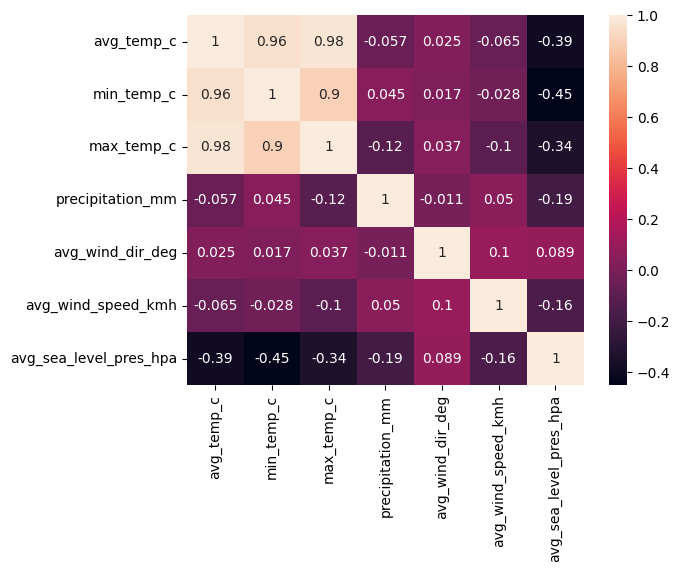

In [7]:
sns.heatmap(df.drop(columns=['season']).corr(), annot=True)

Remove the highly correlated features.

In [8]:
df.columns

Index(['season', 'avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm',
       'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa'],
      dtype='object')

In [9]:
df.drop(columns=['min_temp_c', 'max_temp_c'], inplace=True)

Encode the categorical features.

In [10]:
encoder = OrdinalEncoder()
values = encoder.fit_transform(df[['season']])
df[['season']] = values

In [11]:
df.head()

,season,avg_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
date,,,,,,
2021-01-01,3.0,5.1,0.0,330.0,5.9,1021.2
2021-01-02,3.0,3.0,0.0,330.0,5.9,1021.2
2021-01-03,3.0,6.8,1.3,339.0,8.0,1017.8
2021-01-04,3.0,6.6,3.6,298.0,5.3,1011.3
2021-01-05,3.0,4.3,4.6,11.0,5.1,1014.5


# Feauture Extraction
Select the relevant features for prediction and apply a lag of one, two, and three days to each chosen feature (except `season`), creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [12]:
features = ['avg_temp_c', 'precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']
target = 'avg_sea_level_pres_hpa'

In [13]:
lags = range(3, 0, -1)
list(lags)

[3, 2, 1]

In [14]:
for lag in lags:
    for column in features + [target]:
        df[f"{column}_{lag}"] = df[column].shift(lag)
df.head()

,season,avg_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,avg_temp_c_3,precipitation_mm_3,avg_wind_dir_deg_3,avg_wind_speed_kmh_3,...,avg_temp_c_2,precipitation_mm_2,avg_wind_dir_deg_2,avg_wind_speed_kmh_2,avg_sea_level_pres_hpa_2,avg_temp_c_1,precipitation_mm_1,avg_wind_dir_deg_1,avg_wind_speed_kmh_1,avg_sea_level_pres_hpa_1
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,3.0,5.1,0.0,330.0,5.9,1021.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,3.0,3.0,0.0,330.0,5.9,1021.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.1,0.0,330.0,5.9,1021.2
2021-01-03,3.0,6.8,1.3,339.0,8.0,1017.8,NaN,NaN,NaN,NaN,...,5.1,0.0,330.0,5.9,1021.2,3.0,0.0,330.0,5.9,1021.2
2021-01-04,3.0,6.6,3.6,298.0,5.3,1011.3,5.1,0.0,330.0,5.9,...,3.0,0.0,330.0,5.9,1021.2,6.8,1.3,339.0,8.0,1017.8
2021-01-05,3.0,4.3,4.6,11.0,5.1,1014.5,3.0,0.0,330.0,5.9,...,6.8,1.3,339.0,8.0,1017.8,6.6,3.6,298.0,5.3,1011.3


In [15]:
df.drop(columns=features, inplace=True)
df.dropna(axis=0, inplace=True)
df.head()

,season,avg_sea_level_pres_hpa,avg_temp_c_3,precipitation_mm_3,avg_wind_dir_deg_3,avg_wind_speed_kmh_3,avg_sea_level_pres_hpa_3,avg_temp_c_2,precipitation_mm_2,avg_wind_dir_deg_2,avg_wind_speed_kmh_2,avg_sea_level_pres_hpa_2,avg_temp_c_1,precipitation_mm_1,avg_wind_dir_deg_1,avg_wind_speed_kmh_1,avg_sea_level_pres_hpa_1
date,,,,,,,,,,,,,,,,,
2021-01-04,3.0,1011.3,5.1,0.0,330.0,5.9,1021.2,3.0,0.0,330.0,5.9,1021.2,6.8,1.3,339.0,8.0,1017.8
2021-01-05,3.0,1014.5,3.0,0.0,330.0,5.9,1021.2,6.8,1.3,339.0,8.0,1017.8,6.6,3.6,298.0,5.3,1011.3
2021-01-06,3.0,1017.2,6.8,1.3,339.0,8.0,1017.8,6.6,3.6,298.0,5.3,1011.3,4.3,4.6,11.0,5.1,1014.5
2021-01-07,3.0,1015.2,6.6,3.6,298.0,5.3,1011.3,4.3,4.6,11.0,5.1,1014.5,6.2,0.0,18.0,6.7,1017.2
2021-01-08,3.0,1009.7,4.3,4.6,11.0,5.1,1014.5,6.2,0.0,18.0,6.7,1017.2,7.3,0.5,0.0,4.5,1015.2


In [40]:
df.shape

(940, 17)

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [16]:
X, y = df.drop(columns=[target]), df[target]

In [17]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [18]:
forest = RandomForestRegressor()

In [19]:
forest.fit(train_X, train_y)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [20]:
y_pred = forest.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [21]:
print(r2_score(test_y, y_pred))

0.7226884871242862


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [29]:
xgb = XGBRegressor()

In [30]:
xgb.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [31]:
y_pred = xgb.predict(test_X)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [32]:
print(r2_score(test_y, y_pred))

0.6820363720009321


# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune the max_depth (`max_depth`) for the Random Forest model using a cross-validation with grid search and time series split. This involves systematically experimenting with various values for `max_depth` and evaluating the model's performance using cross-validation. Upon determining the most suitable `max_depth` value, evaluate the model's performance on a test set for final assessment.

Hints:
- For grid search use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.
- For cross-validation use the `TimeSeriesSplit` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**

In [34]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)

In [37]:
time_series_split = TimeSeriesSplit(n_splits=5)
time_series_split.get_n_splits(X, y)

5

## Fine-tuning the Random Forest Hyperparameter
Experiment with various values for `max_depth` and evaluate the model's performance using cross-validation.

In [38]:
model = RandomForestRegressor()

In [43]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [79]:
param_grid = {
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [5, 10, 15],
    'n_estimators': [50, 100, 500],
    'n_jobs': [7]
}

In [80]:
cv = GridSearchCV(estimator=model,param_grid=param_grid,cv=time_series_split)

In [81]:
cv.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(criterion='absolute_error',
                                             max_depth=6, n_estimators=50,
                                             n_jobs=7),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'friedman_mse', 'poisson'],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 500], 'n_jobs': [7]})

In [82]:
cv.best_score_

0.6280707215352488

In [83]:
cv.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_jobs=7)

In [84]:
model = cv.best_estimator_

In [85]:
y_pred = model.predict(test_X)

## Final Assessment of the Model Performance
Upon determining the most suitable `max_depth` value, evaluate the model's performance on a test set for final assessment.

In [86]:
print(r2_score(test_y, y_pred))

0.663517991875405
